# Zillow top ROI Zipcodes for Realestate

## Overview
This project involves analyzing housing data from Zillow to determine the top 5 US zip codes for Real Estate, Inc. to build its next multi-family residential complex. The focus is on metropolitan areas with high activity and density, and median home prices.

## Approach
My approach to this project will involve:
Using Exploratory Data Analysis to identify the top 20% of zip codes in terms of size rank.
Selecting zip codes with average home prices within 1.5 deciles of the median.
Calculating periodic returns and conducting time series analysis to forecast returns for the next year.
The time series analysis will follow the Box-Jenkins method, which involves:

Identifying an appropriate model for the data.
Estimating model parameters using the data.
Diagnosing the fitted model and evaluating potential improvements.

### Time Series Modeling Summary:

Time series modeling is a statistical method used to analyze and forecast data that changes over time, such as stock prices, sales, weather, etc. It involves analyzing past data to understand patterns and trends, and then using that information to make predictions about future values. The goal is to develop a model that accurately captures the underlying patterns in the data and can be used to make accurate predictions.

### In simple terms:

Time series modeling is like trying to predict what will happen next in a story. Just like a story has events that happen one after the other, time series data has values that change over time. To make a prediction about what will happen next in the story, we look at what has happened in the past.

In the same way, to make predictions about future values in time series data, we look at the past values. We try to find patterns and trends in the data and use that information to make an educated guess about what will happen next. This way, we can use the data from the past to predict what will happen in the future.

### Import Libraries

In [1]:
#Import the necessary libraries for EDA, visualization and time series modelling.
#Data visualization and manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import warnings
warnings.simplefilter('ignore')
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     # Line that is not converging
#     likev = mdf.profile_re(0, dist_low=0.1, dist_high=0.1)
plt.style.use('ggplot')
%matplotlib inline
#Time series analysis tools.
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import pmdarima as pm

### Create Helper Functions:

In [2]:
#Helper Functions
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

#Convert the data into long format.
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def acf_pacf(df,alags=48,plags=48):
    #Create figure
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    #Make ACF plot
    plot_acf(df,lags=alags, zero=False,ax=ax1)
    #Make PACF plot
    plot_pacf(df,lags=plags, ax=ax2)
    plt.show()

def seasonal_plots(df,N=13,lags=[12,24,36,48,60,72]):
    #Differencing the rolling mean to find seasonality in the resulting acf plot.
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = TS_70808 - TS_70808.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();
    
def train_test(df):
    #Set trainning dsata before 2016
    train = df[:'2015-04']
    #Set test data starting 2016
    test = df['2015-05':]
    return train, test

def model_fit(df,pdq=(1,0,1),pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

def test_RMSE(df,pdq=(1,0,1),pdqs=(0,0,0,1), display=True):
    X = df.values
    train, test = X[:-36],X[-36:]
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-36:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

def train_RMSE(train, results, display = True):
    train_pred = results.predict(-36)
    rmse = sqrt(MSE(train[-36:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()

def forecast_model(df,pdq=(1,0,1),pdqs=(0,0,0,1), display=True,zc='input zipcode'):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

### EDA

In [3]:
df = pd.read_csv('zillow_data.csv')
print(df.info(),'\n')
print(f'Unique zipcodes: {df.RegionName.nunique()}')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB
None 

Unique zipcodes: 14723


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Based on my initial exploratory data analysis, the data is in a wide format. Later in the project, I will reshape the data into a long format. The data contains 14,723 unique zip codes, so the next step is to pick the zip codes that meet Real Estate, Inc.'s target market criteria.

In [4]:
#Get top 20% of highly urbanized zipcodes
sr_desc = df["SizeRank"].describe()
print(sr_desc, "\n")

#Find the 20% cutoff value
sr_20_cutoff = df["SizeRank"].quantile(0.20)
print("Size Rank 20% cutoff value: ", sr_20_cutoff)

#Select zipcodes with SizeRank below the 20% cutoff
selected_zipcodes = df[df["SizeRank"] < sr_20_cutoff]

#Keep only relevant columns (zipcodes and values) and remove others
zc_top20 = selected_zipcodes.drop(["RegionID", "City", "State", "Metro", "CountyName", "SizeRank"], axis=1)

#Count the number of selected zipcodes
zc_count = len(zc_top20)
print("Number of selected zipcodes: ", zc_count)

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64 

Size Rank 20% cutoff value:  2945.4
Number of selected zipcodes:  2945


I reduced the number of zipcodes to consider from 14,723 to 2,945. Next, I will look at zipcodes with an average value close to the median, calculated using last year's data to represent current prices.

In [5]:
# Calculate average value of last year's data for each zipcode
zc_top20['yr_avg'] = zc_top20.iloc[:, -12:].mean(axis=1, skipna=True)

# Get summary statistics for average value of each zipcode
print(zc_top20['yr_avg'].describe(), '\n')

# Identify the 60% quantile for average value
q_60 = zc_top20['yr_avg'].quantile(0.60)
print(f"60% quantile for average value: {round(q_60, 2)}")

# Identify the 35% quantile for average value
q_35 = zc_top20['yr_avg'].quantile(0.35)
print(f"35% quantile for average value: {round(q_35, 2)}")

# Select zipcodes with average value between the 60% and 35% quantiles
zc_pref = zc_top20[(zc_top20['yr_avg'] < q_60) & (zc_top20['yr_avg'] > q_35)]

# Print number of selected zipcodes
print(f"Number of selected zipcodes: {len(zc_pref)}")

count    2.945000e+03
mean     3.730666e+05
std      5.836511e+05
min      3.632500e+04
25%      1.691333e+05
50%      2.484083e+05
75%      3.978333e+05
max      1.858138e+07
Name: yr_avg, dtype: float64 

60% quantile for average value: 290211.67
35% quantile for average value: 198641.67
Number of selected zipcodes: 736


The number of zipcodes to focus on is now 736 because they match what the real estate company wants. The next step is to check how good an investment these zipcodes have been in the past by looking at how much money was made, how much the price changed, and how risky the investment is.

In [6]:
def calculate_investment_data(df):
    df['ROI'] = (df['2018-04'] / df['1996-04']) - 1
    df['std'] = df.loc[:, '1996-04':'2018-04'].std(skipna=True, axis=1)
    df['mean'] = df.loc[:, '1996-04':'2018-04'].mean(skipna=True, axis=1)
    df['CV'] = df['std'] / df['mean']
    return df

zc_pref = calculate_investment_data(zc_pref)
zc_pref[['RegionName','std','mean','ROI','CV']].head()

,RegionName,std,mean,ROI,CV
11,32162,53805.394161,183692.830189,1.493069,0.292910
14,37013,19771.938500,139191.698113,0.885231,0.142048
17,37211,36496.608464,147387.924528,1.698672,0.247623
18,78660,24894.592870,168193.584906,0.748020,0.148012
22,77573,29647.359699,183261.509434,0.848656,0.161776


In [7]:
# Get summary statistics of CV
cv_stats = zc_pref["CV"].describe()
print(cv_stats)

# Find the upper limit of CV based on risk tolerance
upper_limit = zc_pref["CV"].quantile(0.6)
print("Upper limit of CV:", upper_limit)

# Get the top 5 zipcodes with the highest ROI within the risk tolerance
best_5 = zc_pref[zc_pref["CV"] < upper_limit].nlargest(5, "ROI")
print("\nBest 5 zipcodes:")
print(best_5[["RegionName", "ROI", "CV"]])

count    736.000000
mean       0.238700
std        0.080020
min        0.056119
25%        0.171094
50%        0.226459
75%        0.291877
max        0.453303
Name: CV, dtype: float64
Upper limit of CV: 0.25459687610566145

Best 5 zipcodes:
      RegionName       ROI        CV
1784       70808  2.258519  0.251359
1877       29461  2.061224  0.249053
2213        3820  1.988142  0.248366
1375       52722  1.948396  0.244641
2931       70809  1.930894  0.239323


#### Display zipcode location names

In [8]:
#Get Location Names
best5_zipcodes = list(best_5.RegionName.values)
for i in best5_zipcodes:
    city = df[df['RegionName']==i].City.values[0]
    state = df[df['RegionName']==i].State.values[0]
    print(f'Zipcode : {i} \nLocation: {city}, {state}\n')

Zipcode : 70808 
Location: Baton Rouge, LA

Zipcode : 29461 
Location: Moncks Corner, SC

Zipcode : 3820 
Location: Dover, NH

Zipcode : 52722 
Location: Bettendorf, IA

Zipcode : 70809 
Location: Baton Rouge, LA



I found the top 5 zipcodes that meet Real Estate, Inc's preferences for home values and size rank, with the highest return on investment considering their risk profile. Now I'll analyze these zipcodes to make accurate predictions.

### Time Series Analysis

To start, I'll transform the wide-format data of 5 zipcodes into long-form time series. I"ll plot them to find the best model.

In [9]:
# Get the time series data for the 5 zipcodes
TS_zc5 = best_5.drop(columns=['yr_avg', 'std', 'mean', 'ROI', 'CV'], axis=1)
TS_zc5 = melt_data(TS_zc5).set_index('time')
print('Time series data for the 5 zipcodes:')
print(TS_zc5.head())

# Create separate time series for each zipcode
dfs_ts = []
zipcodes = TS_zc5.RegionName.unique()
for zc in zipcodes:
# Create a dataframe for each zipcode with monthly frequency
    df = TS_zc5[TS_zc5['RegionName'] == zc].asfreq('MS')
    dfs_ts.append(df)

# Print the time series of zipcode 70808
print('\nZipcode 70808 time series:')
print(dfs_ts[0].head())

Time series data for the 5 zipcodes:
            RegionName     value
time                            
1996-04-01       70808   85100.0
1996-04-01       29461   68600.0
1996-04-01        3820  101200.0
1996-04-01       52722   71700.0
1996-04-01       70809   73800.0

Zipcode 70808 time series:
            RegionName    value
time                           
1996-04-01       70808  85100.0
1996-05-01       70808  85600.0
1996-06-01       70808  86000.0
1996-07-01       70808  86600.0
1996-08-01       70808  87200.0


In [10]:
for i in range(len(dfs_ts)):
    zipcode = dfs_ts[i].RegionName[0]
    print(f'Value descriptive statistics for zipcode {zipcode}:')
    print(dfs_ts[i].value.describe(), '\n')

Value descriptive statistics for zipcode 70808:
count       265.000000
mean     177707.547170
std       44668.407286
min       85100.000000
25%      142500.000000
50%      196900.000000
75%      208000.000000
max      277300.000000
Name: value, dtype: float64 

Value descriptive statistics for zipcode 29461:
count       265.000000
mean     145173.207547
std       36155.846366
min       68000.000000
25%      115700.000000
50%      157300.000000
75%      168500.000000
max      210000.000000
Name: value, dtype: float64 

Value descriptive statistics for zipcode 3820:
count       265.000000
mean     213244.905660
std       52962.689684
min      101200.000000
25%      188500.000000
50%      226100.000000
75%      250600.000000
max      302400.000000
Name: value, dtype: float64 

Value descriptive statistics for zipcode 52722:
count       265.000000
mean     155742.264151
std       38100.881176
min       70000.000000
25%      133400.000000
50%      168300.000000
75%      183500.000000
max   

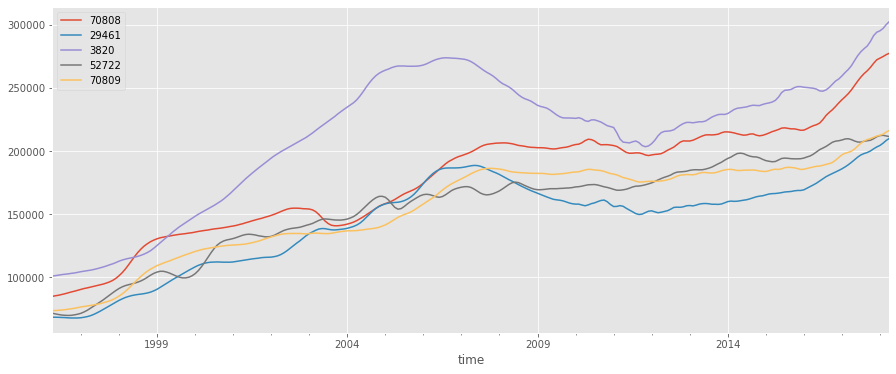

In [11]:
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].RegionName[0],figsize=(15,6))
    plt.legend()

The plot shows that the values are increasing over time, which is typical for the housing market. It would be more useful to compare these zipcodes based on monthly returns instead of just prices because returns can be compared to each other and prices depend on previous prices.

In [12]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret']=np.nan*len(dfs_ts[zc])
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1]= (dfs_ts[zc].value.iloc[i+1] / dfs_ts[zc].value.iloc[i]) - 1        

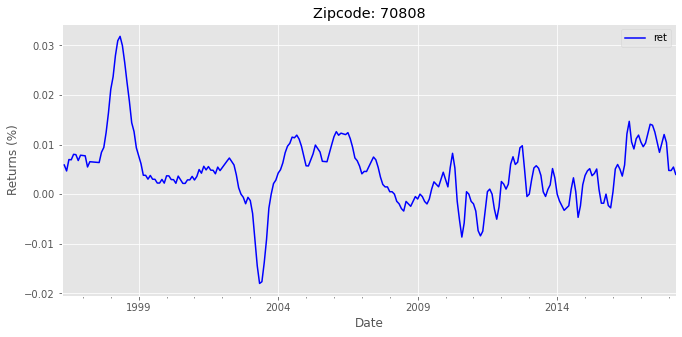

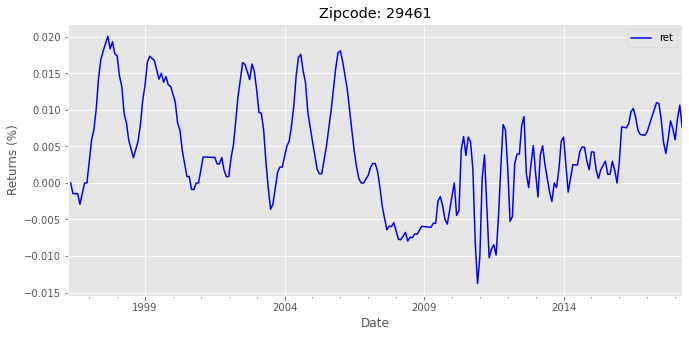

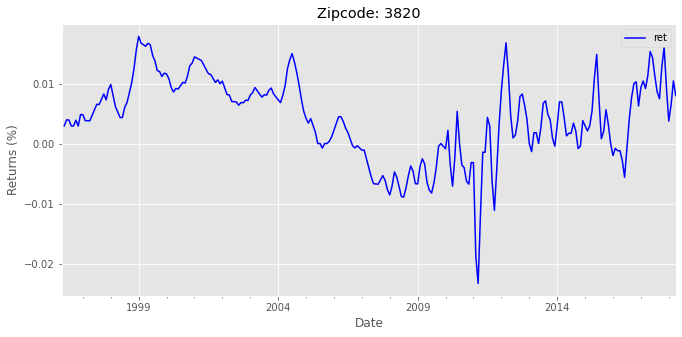

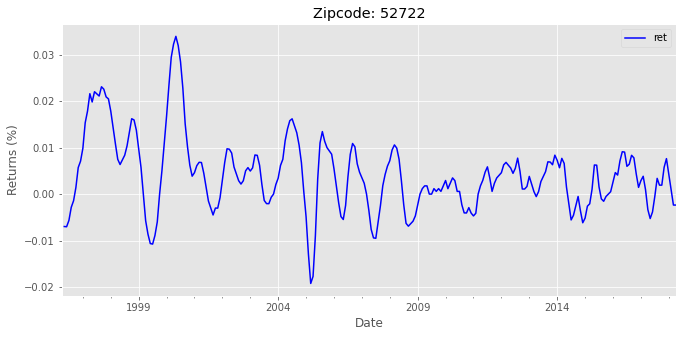

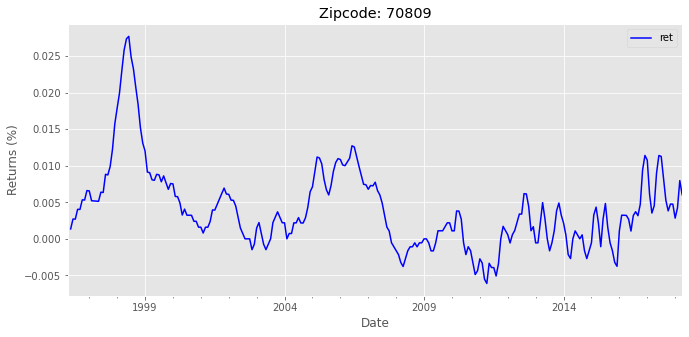

In [13]:
#Plot the monthly returns of each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].ret.plot(figsize=(11,5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

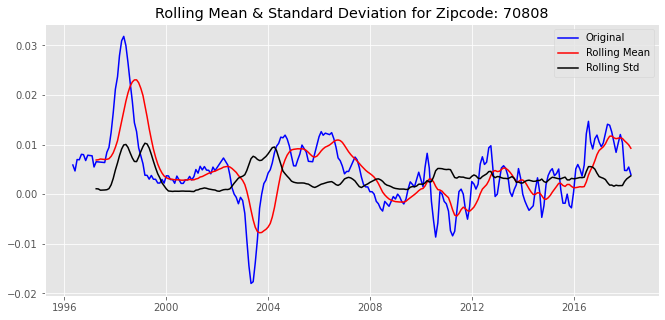

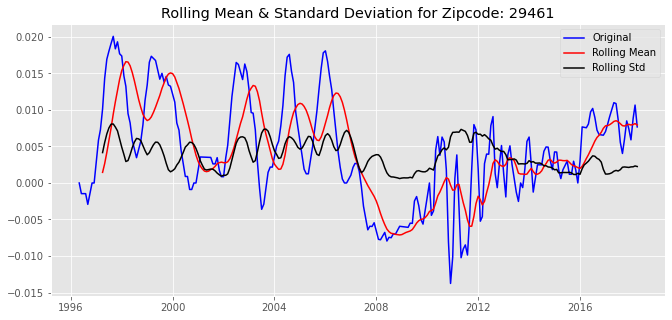

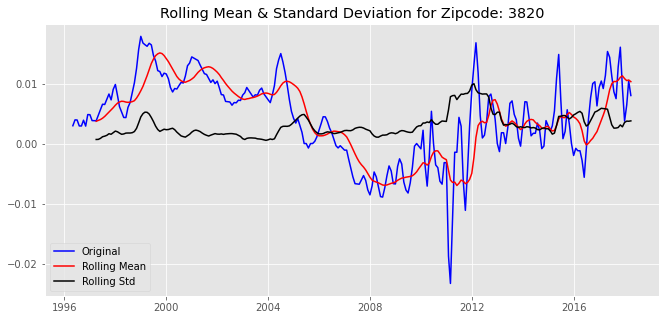

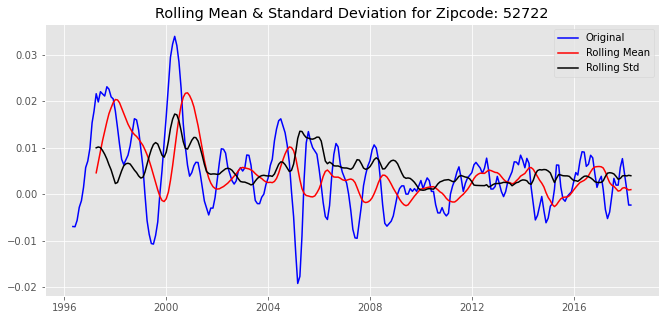

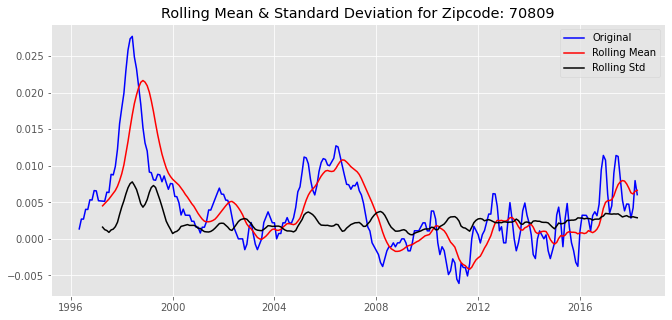

In [14]:
#Plot each of the zipcodes' returns with their respective rolling mean and rolling standard deviation.
#Vizually test for stationarity.
for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].ret.rolling(window = 12, center = False).mean()
    rolstd = dfs_ts[i].ret.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].ret, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

We will use a test called Augmented Dickey-Fuller to see if the data looks like it doesn't change over time (stationary). The test has two ideas: the data is not stationary or the data is stationary. We want to see if the data is stationary and we will do this by setting a confidence level of 95%. If the test result shows a p-value of less than 0.05, we will consider the data as stationary.

In [15]:
from statsmodels.tsa.stattools import adfuller

for i in range(5):
    results = adfuller(dfs_ts[i].ret.dropna())
    print(f"ADFuller test results for zipcode {dfs_ts[i].RegionName[0]}")
    pvalue = results[1]
    if pvalue > 0.05:
        print("Fail to reject the null hypothesis. Data is not stationary.")
    else:
        print("Reject the null hypothesis. Data is stationary.")
    print("\n")


ADFuller test results for zipcode 70808
Reject the null hypothesis. Data is stationary.


ADFuller test results for zipcode 29461
Fail to reject the null hypothesis. Data is not stationary.


ADFuller test results for zipcode 3820
Fail to reject the null hypothesis. Data is not stationary.


ADFuller test results for zipcode 52722
Reject the null hypothesis. Data is stationary.


ADFuller test results for zipcode 70809
Fail to reject the null hypothesis. Data is not stationary.




Two zipcodes monthly return time series are stationary. I'll look at the difference of the other 3 zipcodes to check on the effect on stationarity.

In [16]:
for i in [1,2,4]:
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    pvalue = results[1]
    if pvalue > 0.05:
        print("Fail to reject the null hypothesis. Data is not stationary.")
    else:
        print("Reject the null hypothesis. Data is stationary.")
    print("\n")


ADFuller test p-value for zipcode: 29461
Reject the null hypothesis. Data is stationary.


ADFuller test p-value for zipcode: 3820
Reject the null hypothesis. Data is stationary.


ADFuller test p-value for zipcode: 70809
Reject the null hypothesis. Data is stationary.




After taking the first difference, the p-values decreased dramatically. The integration of the SARIMA model is estimated at 0 for zipcodes 52722 and 70808, and 1 for the others.

In [17]:
#Instantiate individual time series for each of the zipcodes.
TS_70808 = dfs_ts[0].ret.dropna()#Zipcode 70808 monthly returns time series

TS_29461 = dfs_ts[1].ret.dropna()#Zipcode 29461 monthly returns time series
TS_29461d = dfs_ts[1].ret.diff().dropna()#Zipcode 29461 monthly returns differenced time series

TS_3820 = dfs_ts[2].ret.dropna()#Zipcode 3820 monthly returns time series
TS_3820d = dfs_ts[2].ret.diff().dropna()#Zipcode 3820 monthly returns differenced time series

TS_52722 = dfs_ts[3].ret.dropna()#Zipcode 52722 monthly returns time series

TS_70809 = dfs_ts[4].ret.dropna()#Zipcode 70809 monthly returns time series
TS_70809d = dfs_ts[4].ret.diff().dropna()#Zipcode 70809 monthly returns differenced 

#### Zipcode : 70808 
#### Location: Baton Rouge, LA

I'll plot the ACF and PACF to find the p and q parameters of this zipcode's SARIMA model. 

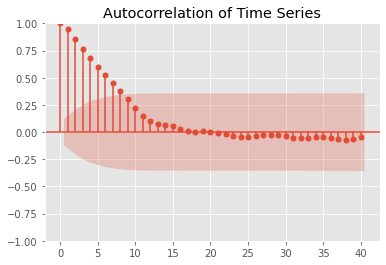

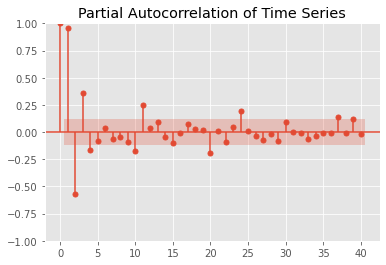

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# plot the autocorrelation of the time series
plot_acf(TS_70808, lags=40, alpha=0.05, title='Autocorrelation of Time Series')
plt.show()

# plot the partial autocorrelation of the time series
plot_pacf(TS_70808, lags=40, alpha=0.05, title='Partial Autocorrelation of Time Series')
plt.show()

The ACF and PACF plots help to determine the parameters for an ARIMA model. The ACF plot shows that the moving average (MA) parameter is probably 0 and the autoregressive (AR) parameter is around 3 or 4. The PACF plot shows that there are still significant values after lag 4, which suggests that a full ARMA model with both AR and MA parameters might be needed. The next step is to check for seasonality in the returns.

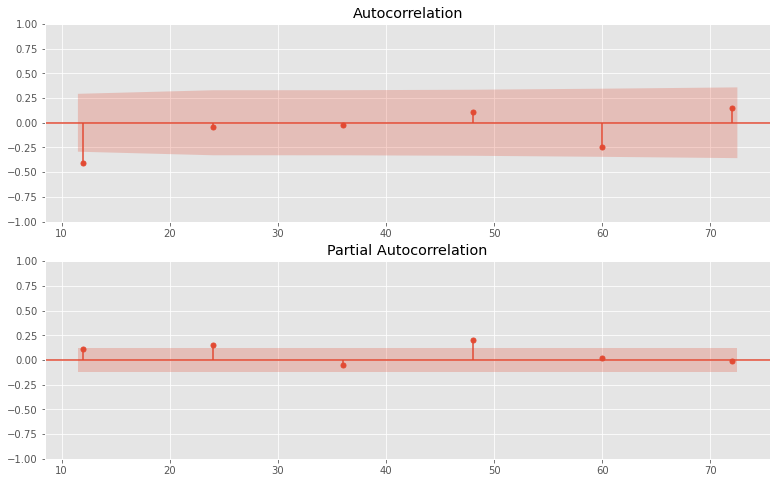

In [19]:
seasonal_plots(TS_70808, N=13)

To see if there's a pattern that happens every 12 months in the data, we look at a picture called an ACF plot. If there's a big bump in the picture at 12 months, it means there might be a pattern. But, if the bump doesn't show up in other months, it means there probably isn't a pattern. Now that we know this, we can start using a type of model called SARIMA to try and understand how the data changes each month.

In [20]:
import pmdarima as pm
# Use the `auto_arima` function to find the best parameters
best_params = pm.auto_arima(TS_70808, information_criterion='aic', m=12, d=0,
                            start_p=1, start_q=1, max_p=3, max_q=3,
                            stepwise=True, trace=True, error_action='ignore',
                            suppress_warnings=True)

# Print the results
print(best_params)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2604.909, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1884.406, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2419.957, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2198.259, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1789.510, Time=0.05 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2608.842, Time=0.81 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2595.499, Time=0.31 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2602.323, Time=2.25 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2604.441, Time=1.47 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2607.121, Time=4.82 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-2533.681, Time=0.83 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=-2606.199, Time=2.10 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-2605.020, Time=1.68 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-1885.151, Time=0.43 sec
 ARIM

#### Result summary:

The algorithm tried out different combinations of ARIMA parameters (p, d, q for non-seasonal and P, D, Q for seasonal) to find the best model that fits the time series data based on the AIC (Akaike Information Criterion) value.

The best model is ARIMA(1,0,1)(0,0,1)[12] intercept with an AIC of -2603.803, meaning it is the model that fits the data best according to the AIC criterion among all the models tried. The process took a total of 7.830 seconds.

So...
* p = 1, q = 1
* P = 0, Q = 1

Using these parameters, we'll fit the SARIMA model.

                                     SARIMAX Results                                      
Dep. Variable:                                ret   No. Observations:                  228
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                1132.586
Date:                            Tue, 31 Jan 2023   AIC                          -2257.171
Time:                                    02:57:00   BIC                          -2243.454
Sample:                                05-01-1996   HQIC                         -2251.637
                                     - 04-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9328      0.018     52.833      0.000       0.898       0.967
ma.L1          0.6121      0.051   

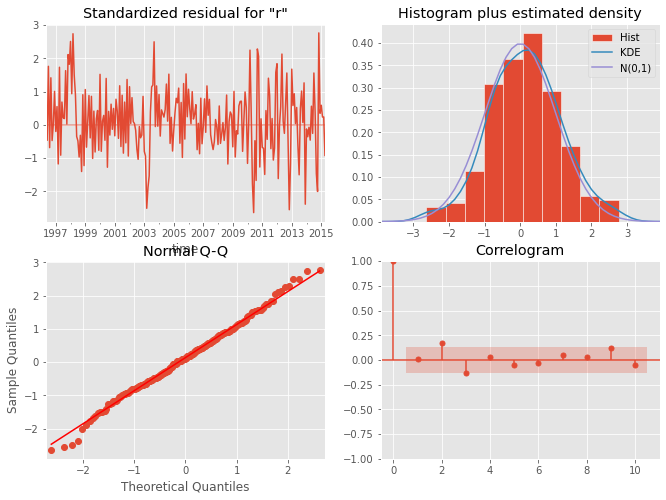

In [21]:
#Fit the SARIMA model and get results.
pdq = (1,0,1)
pdqs = (0,0,1,12)
train, test, results = model_fit(TS_70808,pdq=pdq,pdqs=pdqs)

The seasonal ARIMA model seems to fit the monthly return data well, based on the normal distribution of residuals. However, there is some autocorrelation in the residuals, as indicated by a test that shows a 4% significance. Despite this, the model has the best result so far after multiple trials and errors. The next step is to test the model's accuracy by calculating the RMSE for both the training and testing data.

SARIMA model RMSE on train data: 0.00196


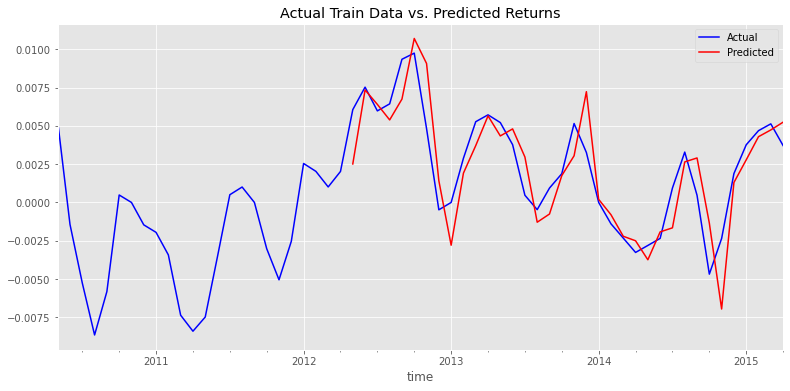

In [22]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00201


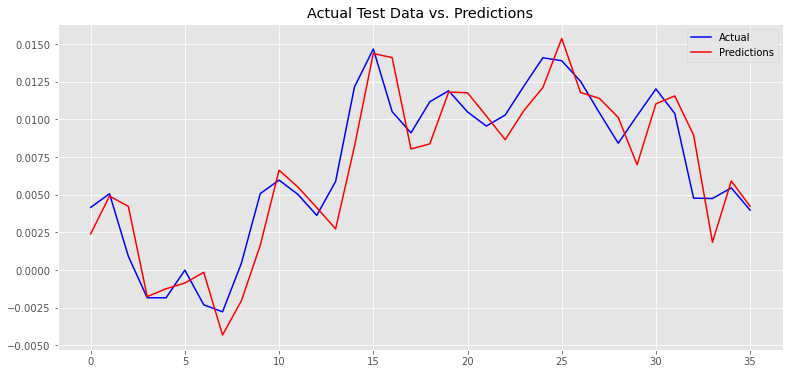

In [23]:
import warnings
warnings.filterwarnings("ignore")
test_RMSE(TS_70808,pdq=pdq,pdqs=pdqs, display=True)

The prediction results are accurate because the difference between the actual values and the predicted values is small and similar for both train and test data. Now, the next step is to make future predictions for the next 1, 3, 5, and 10 years for the first zip code, and repeat this process for the other 4 zip codes.

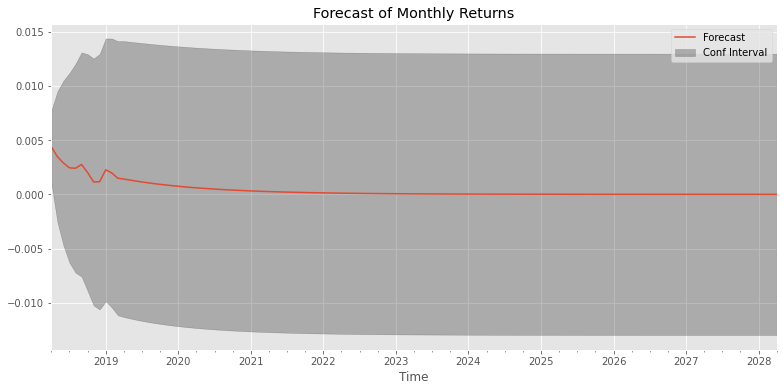

Total expected return in 1 year: 2.88%
Total expected return in 3 years: 4.62%
Total expected return in 5 year: 4.94%
Total expected return in 10 years: 5.01%


In [24]:
ret_70808 = forecast_model(TS_70808,pdq=pdq,pdqs=pdqs,zc=70808)

#### Zipcode : 3820 
#### Location: Dover, NH

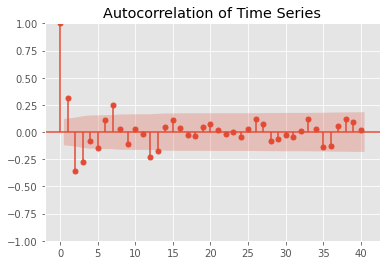

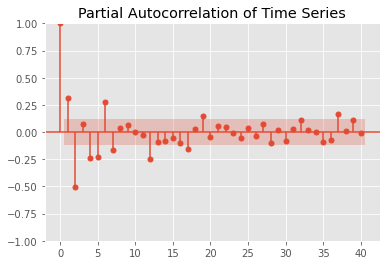

In [25]:
# plot the autocorrelation of the time series
plot_acf(TS_3820d, lags=40, alpha=0.05, title='Autocorrelation of Time Series')
plt.show()

# plot the partial autocorrelation of the time series
plot_pacf(TS_3820d, lags=40, alpha=0.05, title='Partial Autocorrelation of Time Series')
plt.show()

In [ ]:
# come back to change the max p
# q look at previous errors and go from there

In [26]:
# Use the `auto_arima` function to find the best parameters
best_params = pm.auto_arima(TS_3820d, information_criterion='aic', m=12, d=0,
                            start_p=1, start_q=1, max_p=3, max_q=3,
                            stepwise=True, trace=True, error_action='ignore',
                            suppress_warnings=True)

# Print the results
print(best_params)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2425.679, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2352.247, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2388.410, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2438.048, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2354.234, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2420.521, Time=0.16 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2428.616, Time=0.62 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-2447.377, Time=0.57 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2439.832, Time=1.14 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-2379.870, Time=0.39 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2446.542, Time=0.66 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=-2448.096, Time=1.61 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=-2395.185, Time=0.29 sec
 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=-2401.009, Time=0.88 sec
 ARIM

#### Result summary:

The algorithm tried out different combinations of ARIMA parameters (p, d, q for non-seasonal and P, D, Q for seasonal) to find the best model that fits the time series data based on the AIC (Akaike Information Criterion) value.

The best model is ARIMA(0,0,3)(0,0,2)[12] intercept with an AIC of -2458.933, meaning it is the model that fits the data best according to the AIC criterion among all the models tried. The process took a total of 39.887 seconds.

So...
* p = 0, q = 4
* P = 0, Q = 0

Using these parameters, we'll fit the SARIMA model.

                               SARIMAX Results                                
Dep. Variable:                    ret   No. Observations:                  227
Model:               SARIMAX(0, 1, 4)   Log Likelihood                1084.422
Date:                Tue, 31 Jan 2023   AIC                          -2158.844
Time:                        02:59:03   BIC                          -2141.741
Sample:                    06-01-1996   HQIC                         -2151.942
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4160      0.041    -10.088      0.000      -0.497      -0.335
ma.L2         -0.8993      0.046    -19.456      0.000      -0.990      -0.809
ma.L3         -0.2523      0.056     -4.522      0.0

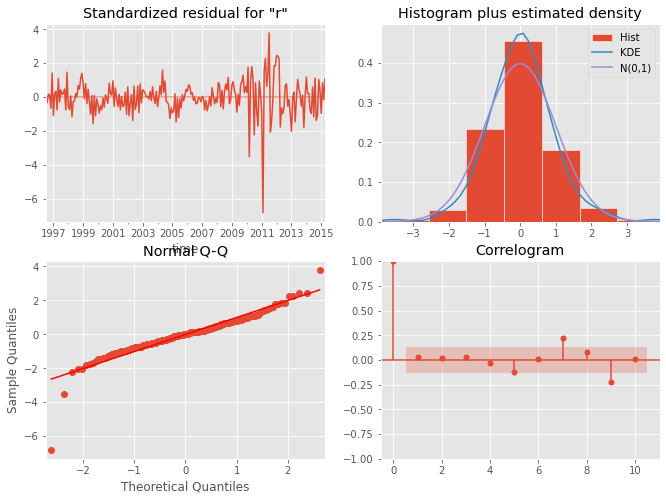

In [28]:
# Fit the SARIMA model and get results.
pdq = (0,1,4)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_3820d,pdq=pdq,pdqs=pdqs)

The residuals are the differences between the actual values and the values predicted by the model. The histogram and Q-Q plots suggest that the residuals are normally distributed, which is a desirable property. However, the autocorrelation plots (correlogram) and the Ljung-Box test suggest that the residuals are not independent, meaning that there is a relationship between the residuals at different time points. This means that the current model needs to be improved to better capture the patterns in the data.

#### More simply:

The residuals (difference between actual and predicted values) appear to be randomly distributed, but the data may still have some hidden patterns or dependencies. The model needs to be improved to better capture these patterns.

SARIMA model RMSE on train data: 0.00174


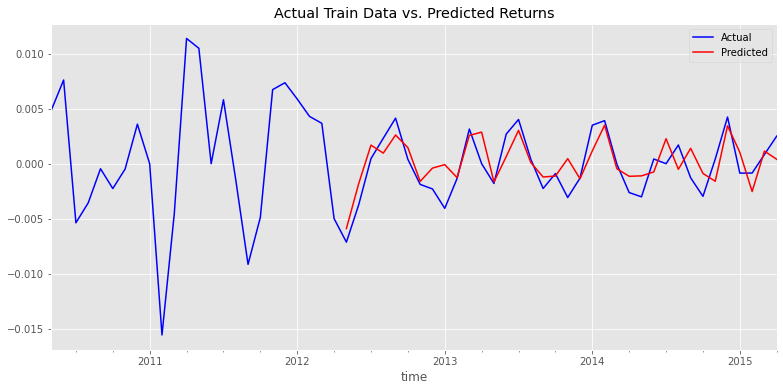

In [29]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00279


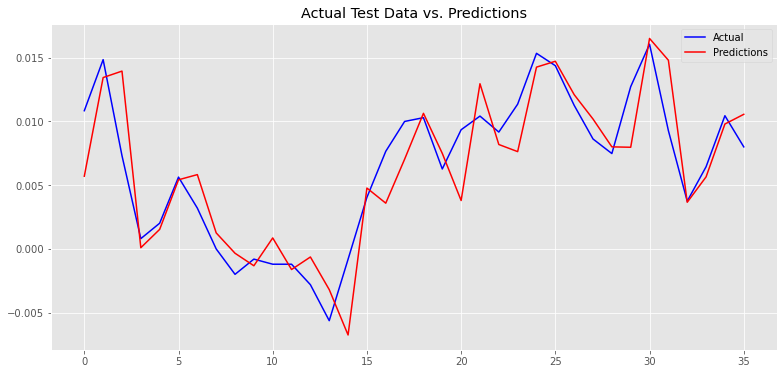

In [30]:
test_RMSE(TS_3820,pdq=pdq,pdqs=pdqs, display=True)

Visually inspecting the difference, our predictions follow the actual data.

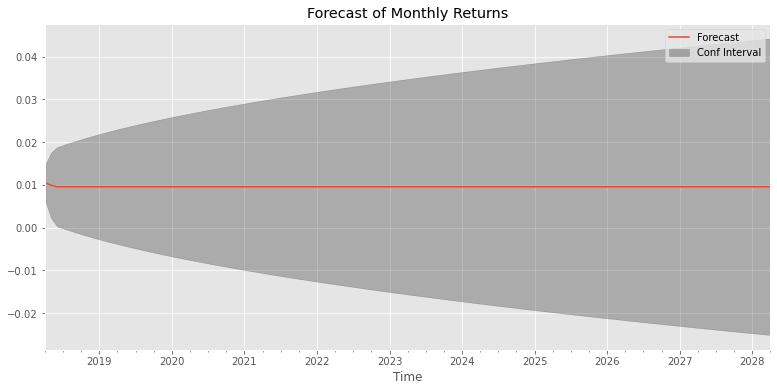

Total expected return in 1 year: 12.24%
Total expected return in 3 years: 41.06%
Total expected return in 5 year: 77.27%
Total expected return in 10 years: 216.85%


In [32]:
ret_3820=forecast_model(TS_3820,pdq=pdq,pdqs=pdqs,zc=3820)

#### Zipcode : 70809 
#### Location: Baton Rouge, LA 

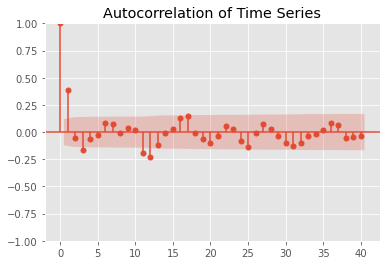

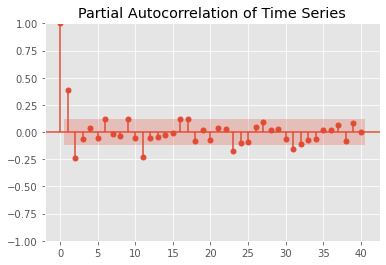

In [33]:
# plot the autocorrelation of the time series
plot_acf(TS_70809d, lags=40, alpha=0.05, title='Autocorrelation of Time Series')
plt.show()

# plot the partial autocorrelation of the time series
plot_pacf(TS_70809d, lags=40, alpha=0.05, title='Partial Autocorrelation of Time Series')
plt.show()

The graphs show that both the past and future values are affecting the present values, so the final model will consider both of these factors.

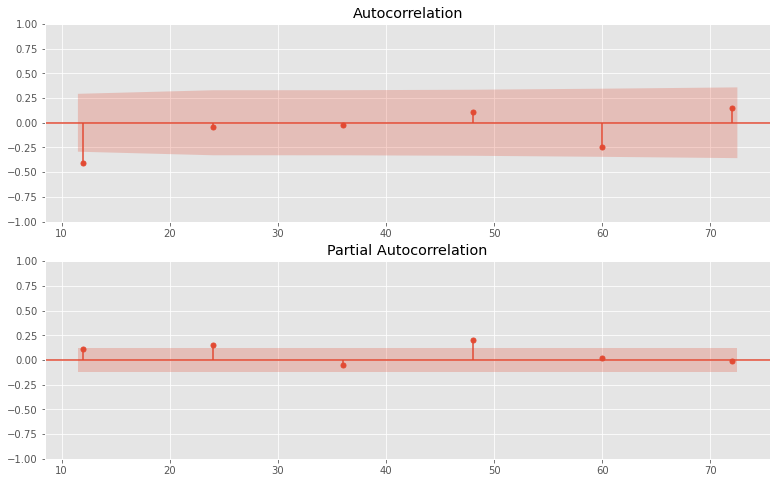

In [34]:
seasonal_plots(TS_70809d, N=13)

The graph shows there may be a pattern in the data that happens every 12 months, but it doesn't show up consistently. So, the next step is to try and find a pattern in the data by using a SARIMA model.

In [39]:
# Use the `auto_arima` function to find the best parameters
best_params = pm.auto_arima(TS_70809, information_criterion='aic', m=12, d=0,
                            start_p=1, start_q=1, max_p=3, max_q=3,
                            stepwise=True, trace=True, error_action='ignore',
                            suppress_warnings=True)

# Print the results
print(best_params)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2715.312, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1980.209, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2536.336, Time=0.51 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2313.027, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1870.503, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2718.419, Time=0.65 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2713.414, Time=0.50 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2699.769, Time=1.36 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2717.301, Time=0.68 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2713.569, Time=1.58 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-2678.190, Time=0.57 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=-2714.339, Time=0.63 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-2719.238, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-2715.464, Time=0.43 sec
 ARIM

#### Result summary:

The algorithm tried out different combinations of ARIMA parameters (p, d, q for non-seasonal and P, D, Q for seasonal) to find the best model that fits the time series data based on the AIC (Akaike Information Criterion) value.

The best model is ARIMA(1,0,3)(1,0,0)[12] intercept with an AIC of -2720.735, meaning it is the model that fits the data best according to the AIC criterion among all the models tried. The process took a total of 27.294 seconds.

So...
* p = 1, q = 3
* P = 1, Q = 0

Using these parameters, we'll fit the SARIMA model.

                                      SARIMAX Results                                      
Dep. Variable:                                 ret   No. Observations:                  228
Model:             SARIMAX(1, 0, 3)x(1, 0, [], 12)   Log Likelihood                1160.548
Date:                             Tue, 31 Jan 2023   AIC                          -2309.095
Time:                                     03:40:07   BIC                          -2288.519
Sample:                                 05-01-1996   HQIC                         -2300.794
                                      - 04-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9589      0.027     35.102      0.000       0.905       1.012
ma.L1          0.5110      

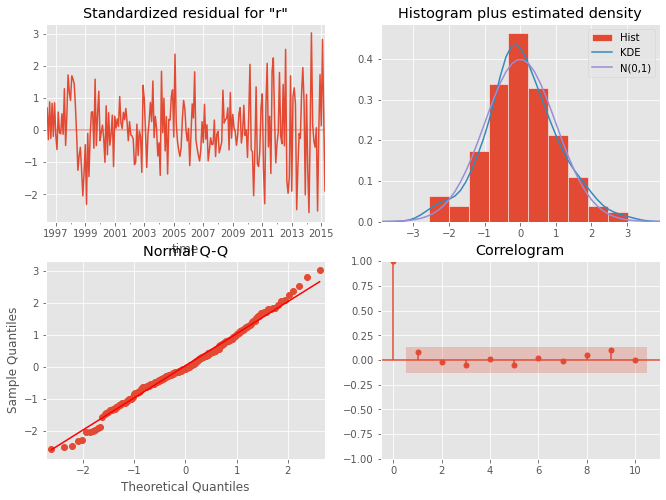

In [40]:
#Fit the SARIMA model and get results.
pdq = (1,0,3)
pdqs = (1,0,0,12)
train, test, results = model_fit(TS_70809,pdq=pdq,pdqs=pdqs)

The chosen SARIMA model works well for the data of this zip code. The residuals, which are the differences between the actual data and the predictions, are evenly distributed and do not show any pattern. This is confirmed by high p-values in the JB and Q tests, which mean the residuals are probably random noise.

SARIMA model RMSE on train data: 0.00223


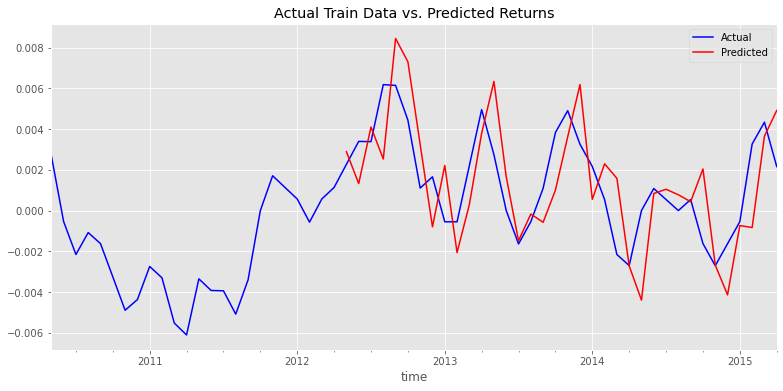

In [41]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00216


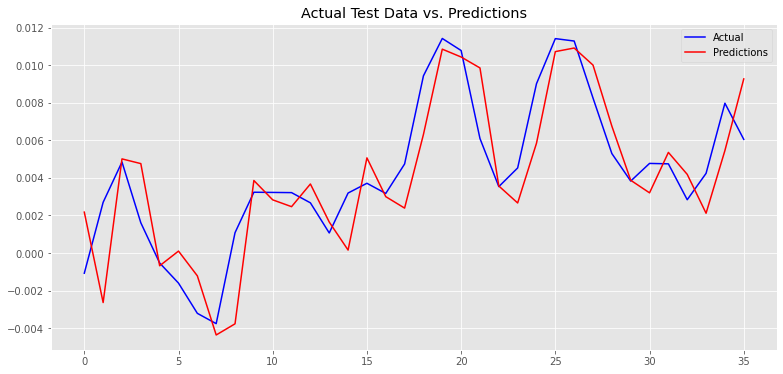

In [42]:
test_RMSE(TS_70809,pdq=pdq,pdqs=pdqs, display=True)

The difference here is small. 

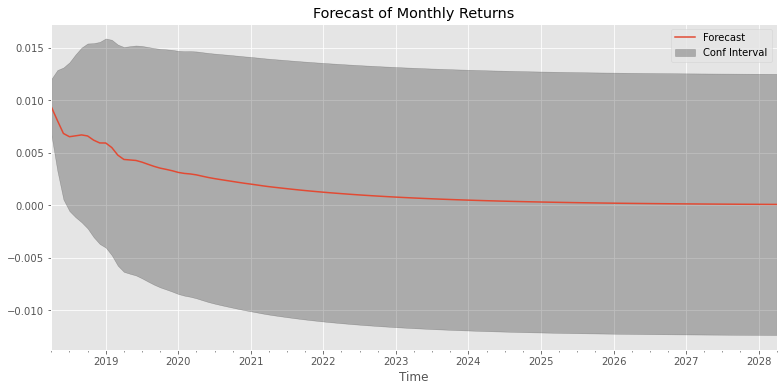

Total expected return in 1 year: 8.17%
Total expected return in 3 years: 16.18%
Total expected return in 5 year: 19.43%
Total expected return in 10 years: 21.3%


In [43]:
ret_70809=forecast_model(TS_70809,pdq=pdq,pdqs=pdqs,zc=70809)

#### Zipcode : 52722 
#### Location: Bettendorf, IA

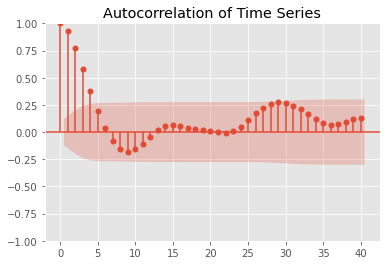

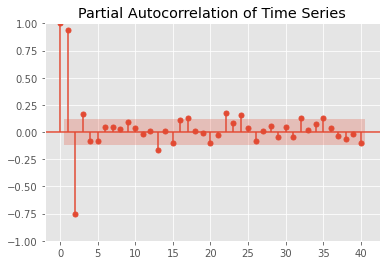

In [45]:
# plot the autocorrelation of the time series
plot_acf(TS_52722, lags=40, alpha=0.05, title='Autocorrelation of Time Series')
plt.show()

# plot the partial autocorrelation of the time series
plot_pacf(TS_52722, lags=40, alpha=0.05, title='Partial Autocorrelation of Time Series')
plt.show()

The plots show that it's likely the model is an AR(p) with p around 3 or 4 and an MA(q) with q equal to 0. But there might still be some important information in the data, so a full ARMA model with both p and q parameters might be needed.

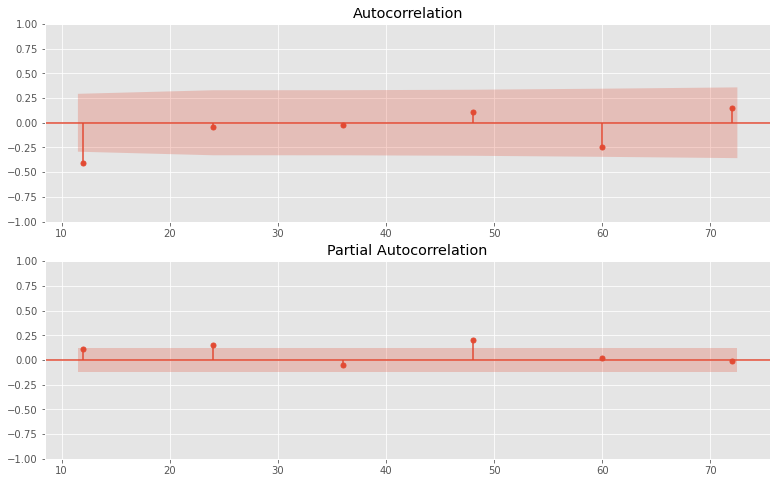

In [46]:
seasonal_plots(TS_52722, N=13)

The data may have a pattern that repeats every 12 months, but it is not clear because the pattern is only found at one point in the data and not at any other points.

In [47]:
# Use the `auto_arima` function to find the best parameters
best_params = pm.auto_arima(TS_52722, information_criterion='aic', m=12, d=0,
                            start_p=1, start_q=1, max_p=3, max_q=3,
                            stepwise=True, trace=True, error_action='ignore',
                            suppress_warnings=True)

# Print the results
print(best_params)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2492.536, Time=1.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1791.282, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2336.340, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2100.907, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1731.754, Time=0.06 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2494.628, Time=0.67 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2496.519, Time=0.28 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2480.510, Time=0.63 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2102.850, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2342.343, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-2569.744, Time=0.43 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=-2560.361, Time=0.42 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=-2567.753, Time=0.69 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-2562.394, Time=0.35 sec
 ARIM

#### Result summary:

The algorithm tried out different combinations of ARIMA parameters (p, d, q for non-seasonal and P, D, Q for seasonal) to find the best model that fits the time series data based on the AIC (Akaike Information Criterion) value.

The best model is ARIMA(2,0,1)(0,0,0)[12] intercept with an AIC of -2562.792, meaning it is the model that fits the data best according to the AIC criterion among all the models tried. The process took a total of 9.967 seconds.

So...
* p = 2, q = 1
* P = 0, Q = 0

Using these parameters, we'll fit the SARIMA model.

                               SARIMAX Results                                
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(2, 0, 1)   Log Likelihood                1116.815
Date:                Tue, 31 Jan 2023   AIC                          -2225.630
Time:                        03:53:30   BIC                          -2211.912
Sample:                    05-01-1996   HQIC                         -2220.095
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6110      0.052     30.818      0.000       1.509       1.713
ar.L2         -0.6972      0.054    -12.899      0.000      -0.803      -0.591
ma.L1          0.2180      0.072      3.034      0.0

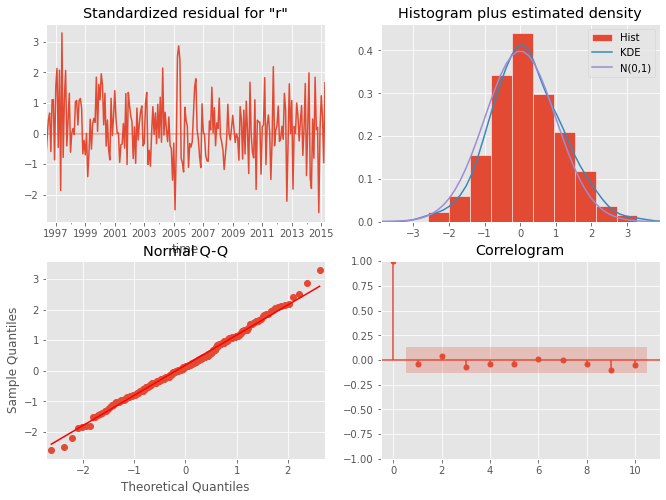

In [49]:
#Fit the SARIMA model and get results.
pdq = (2,0,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_52722,pdq=pdq,pdqs=pdqs)

The residuals, or leftover data, are evenly spread out as shown in the graphs. But, even though the graphs don't show any strong connections between the data, a test shows that there might be some connections at a 95% or even 99% confidence level. This means the model needs to be improved.

SARIMA model RMSE on train data: 0.00206


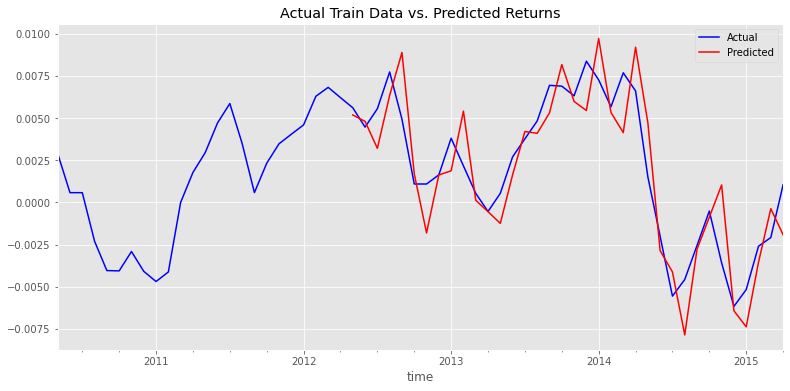

In [50]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00217


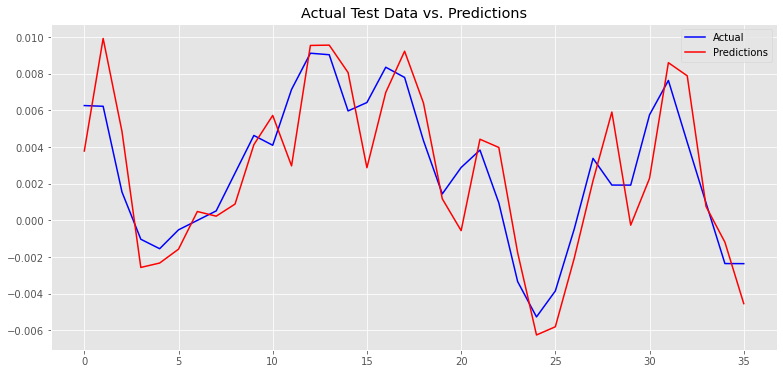

In [51]:
test_RMSE(TS_52722,pdq=pdq,pdqs=pdqs, display=True)

Similar pattern to the actual data. There's not much difference.

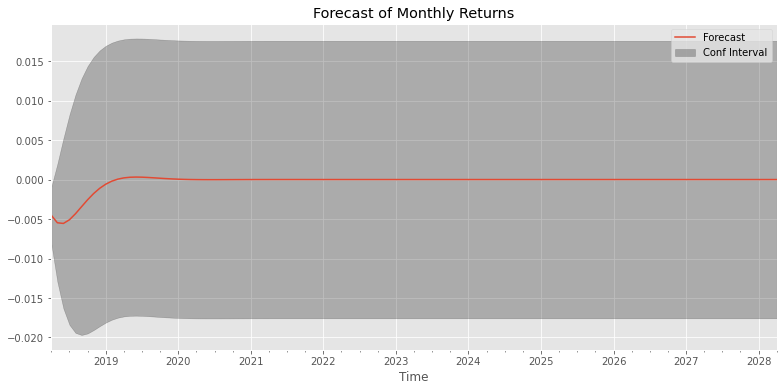

Total expected return in 1 year: -3.41%
Total expected return in 3 years: -3.23%
Total expected return in 5 year: -3.22%
Total expected return in 10 years: -3.22%


In [52]:
ret_52722=forecast_model(TS_52722,pdq=pdq,pdqs=pdqs,zc=52722)

#### Zipcode : 29461 
#### Location: Moncks Corner, SC

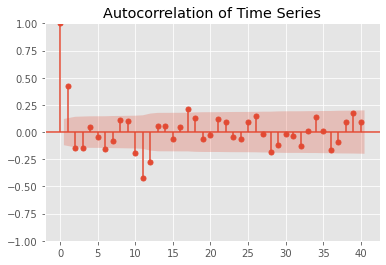

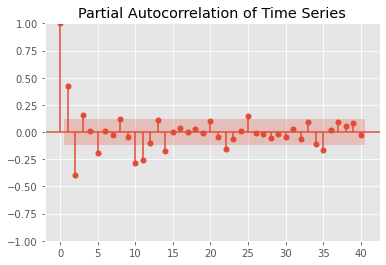

In [54]:
# plot the autocorrelation of the time series
plot_acf(TS_29461d, lags=40, alpha=0.05, title='Autocorrelation of Time Series')
plt.show()

# plot the partial autocorrelation of the time series
plot_pacf(TS_29461d, lags=40, alpha=0.05, title='Partial Autocorrelation of Time Series')
plt.show()

The graphs show that the model will probably have both AR and MA parts. Now let's check if the returns have a pattern that happens at a certain time each year.

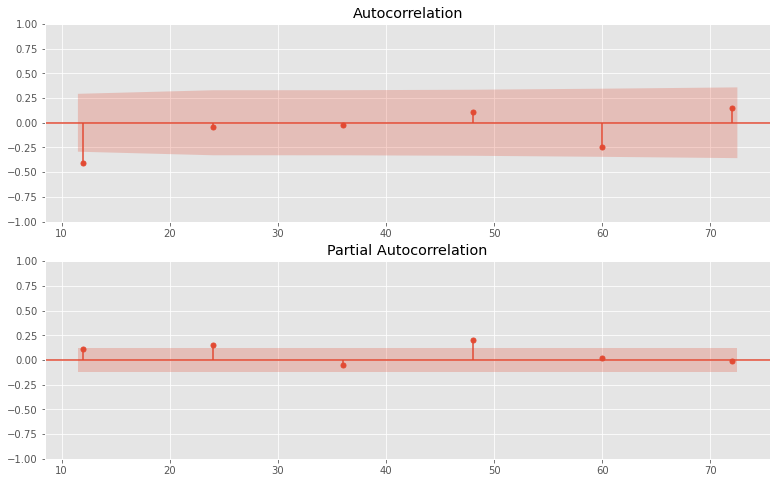

In [55]:
seasonal_plots(TS_29461d, N=13)

It doesn't look like there's seasonality in the data here.

In [58]:
# Use the `auto_arima` function to find the best parameters
best_params = pm.auto_arima(TS_29461, information_criterion='aic', m=12, d=0,
                            start_p=1, start_q=1, max_p=3, max_q=3,
                            stepwise=True, trace=True, error_action='ignore',
                            suppress_warnings=True)

# Print the results
print(best_params)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2503.188, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1862.017, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2330.924, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2167.356, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1781.695, Time=0.03 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2504.853, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2508.768, Time=0.17 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2519.111, Time=0.35 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-2521.183, Time=1.16 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-2528.779, Time=0.83 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-2526.617, Time=1.08 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2528.592, Time=0.68 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=-2172.037, Time=0.96 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-2453.048, Time=0.96 sec
 ARIM

#### Result summary:

The algorithm tried out different combinations of ARIMA parameters (p, d, q for non-seasonal and P, D, Q for seasonal) to find the best model that fits the time series data based on the AIC (Akaike Information Criterion) value.

The best model is ARIMA(2,0,3)(1,0,1)[12] intercept with an AIC of -2519.436, meaning it is the model that fits the data best according to the AIC criterion among all the models tried. The process took a total of 34.935 seconds.

So...
* p = 2, q = 3
* P = 1, Q = 1

Using these parameters, we'll fit the SARIMA model.

                                      SARIMAX Results                                       
Dep. Variable:                                  ret   No. Observations:                  228
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 12)   Log Likelihood                1097.107
Date:                              Tue, 31 Jan 2023   AIC                          -2178.214
Time:                                      04:22:59   BIC                          -2150.780
Sample:                                  05-01-1996   HQIC                         -2167.145
                                       - 04-01-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7211      0.284      2.543      0.011       0.165       1.277
ar.L2          0.18

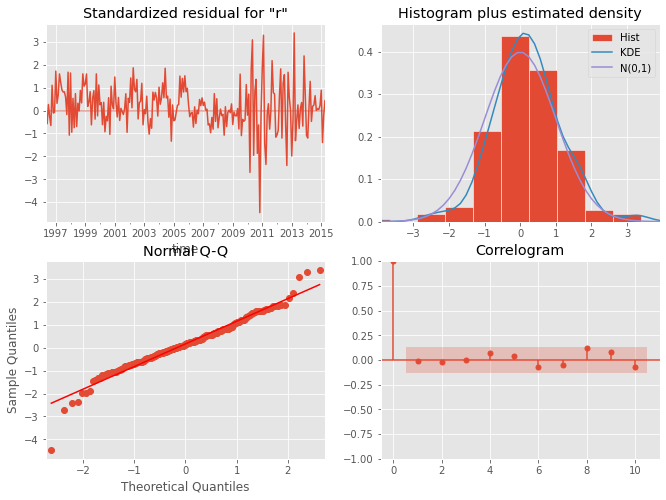

In [59]:
#Fit the SARIMA model and get results.
pdq = (2,0,3)
pdqs = (1,0,1,12)
train, test, results = model_fit(TS_29461,pdq=pdq,pdqs=pdqs)

We tried different models and this one fits the best so far. But, the leftover parts (residuals) are not evenly spread out and have a pattern, as shown by the low p-values from JB and Q tests. This means the model still needs to be improved and doesn't capture all the patterns yet.

SARIMA model RMSE on train data: 0.00223


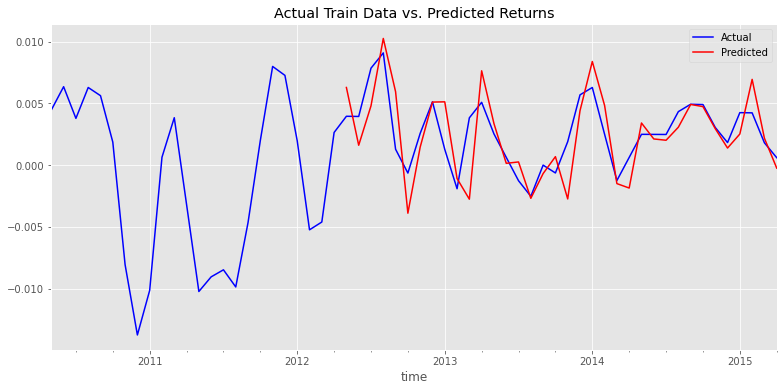

In [60]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00143


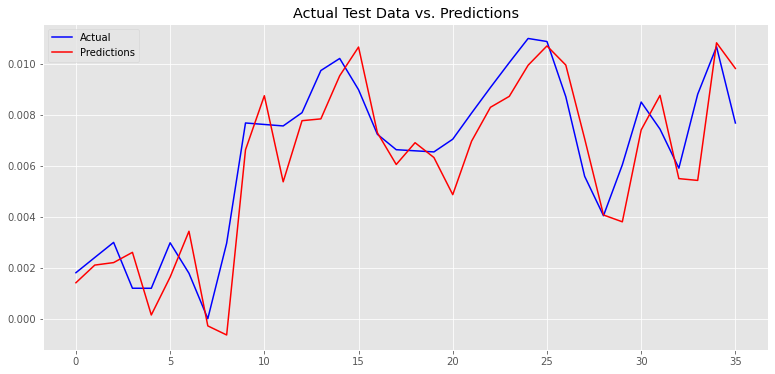

In [61]:
test_RMSE(TS_29461,pdq=pdq,pdqs=pdqs, display=True)

These are both similar. They follow the actual data closely.

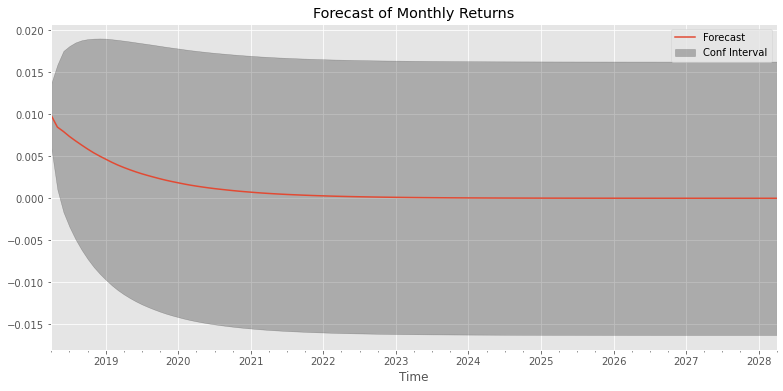

Total expected return in 1 year: 7.87%
Total expected return in 3 years: 12.45%
Total expected return in 5 year: 13.18%
Total expected return in 10 years: 13.32%


In [62]:
ret_29461=forecast_model(TS_29461,pdq=pdq,pdqs=pdqs,zc=29461)

## Conclusion:

We found the top 5 zip codes and performed a time series analysis on them. We projected the total returns for 1,3,5, and 10 years. If you're looking to invest with the highest rate of return, do so in these three zipcodes.

* 3820 - Dover, NH with a 216.85% 10-year ROI.
* 29461 - Moncks Corner, SC with a 13.32% 10-year ROI.
* Baton Rouge, LA with a 21.3% 10-year ROI.

In [1]:
# cap time series off at 5 years